# This notebook

This is the continuation of IrrToProduction but by focusing onn a single plant at a time.

## Goals

- Predict AC_POWER with good accuracy and without overfitting
- Forecast AC_POWER

### Predict AC_POWER

In [1]:
# Import

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.pipeline import  make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
from statsmodels.tsa.deterministic import DeterministicProcess

In [2]:
# Import & Transforms data
def preprocess(d, plant_nb):
    d["generator"] = d["generator"].drop(columns=["SOURCE_KEY", "PLANT_ID", "DC_POWER", "TOTAL_YIELD", "DAILY_YIELD"])
    d['generator']['DATE_TIME'] = pd.to_datetime(d['generator']['DATE_TIME'], format='%d-%m-%Y %H:%M') if plant_nb==1 else pd.to_datetime(d['generator']['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
    d["sensor"] = d["sensor"].drop(columns=["time", "date"])
    X = d['generator'].merge(d["sensor"], on="DATE_TIME").drop(columns=["DATE_TIME"])
    y = X.pop("AC_POWER")
    X['AT_1'] = X['AMBIENT_TEMPERATURE'].shift(1)
    X['MT_1'] = X['MODULE_TEMPERATURE'].shift(1)
    X['I_1'] = X['IRRADIATION'].shift(1)
    X = X.fillna(0)
    return X, y 


p1_X, p1_y = preprocess({"generator": pd.read_csv("dataset/Plant_1_Generation_Data.csv"), 
           "sensor": pd.read_parquet("dataset/parquets/plant_1_updated_sensor")}, 1)

p2_X, p2_y = preprocess({"generator": pd.read_csv("dataset/Plant_2_Generation_Data.csv"), 
           "sensor": pd.read_parquet("dataset/parquets/plant_2_updated_sensor")}, 2)

x_train, x_test, y_train, y_test = train_test_split(p1_X, p1_y, test_size=.5)

In [87]:
# Train
model_search = RandomForestRegressor()
model_search.fit(x_train, y_train)


[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1626
[LightGBM] [Info] Number of data points in the train set: 34389, number of used features: 7
[LightGBM] [Info] Start training from score 304.307083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

RandomizedSearchCV(estimator=LGBMRegressor(), n_iter=500, n_jobs=-1,
                   param_distributions={'lambda_l2': array([0.01  , 0.1325, 0.255 , 0.3775, 0.5   ]),
                                        'learning_rate': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ]),
                                        'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'max_features': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
                                        'n_estimators': array([ 50,  65,  80,  95, 110, 125, 140, 155, 170, 185]),
                                        'subsample': array([0.1 , 0.35, 0.6 , 0.85])})

In [16]:
# Test

metrics = {
    "Name":[],
    "params": [],
    "R2":[], 
    "MAE":[], 
    "MSE":[],
    "RMSE":[],
}

In [91]:
def quick_check(x_train, x_test, y_train, y_test):
    models = {"GBR": GradientBoostingRegressor(),
              "LightGBM": lgb.LGBMRegressor(),
              "RF": RandomForestRegressor(), 
              "DT":DecisionTreeRegressor(), 
              "LR": LinearRegression(), 
              }
    for s, m in models.items():
        m.fit(x_train, y_train)
        preds = m.predict(x_test)
        metrics['Name'].append(f"{s} - Added Lag on set - Plant 2 ")
        metrics['params'].append("Base")
        metrics['R2'].append(r2_score(preds, y_test))
        metrics['MAE'].append(mean_absolute_error(preds, y_test))
        metrics['MSE'].append(mean_squared_error(preds, y_test, squared=True))
        metrics['RMSE'].append(mean_squared_error(preds, y_test, squared=False))
quick_check(x_train, x_test, y_train, y_test) 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1626
[LightGBM] [Info] Number of data points in the train set: 34389, number of used features: 7
[LightGBM] [Info] Start training from score 304.307083


In [88]:
preds = model_search.predict(x_test)
metrics['Name'].append("Light GBM Shallow tuned - Added Lag on set")
metrics['params'].append("Base")
metrics['R2'].append(r2_score(preds, y_test))
metrics['MAE'].append(mean_absolute_error(preds, y_test))
metrics['MSE'].append(mean_squared_error(preds, y_test, squared=True))
metrics['RMSE'].append(mean_squared_error(preds, y_test, squared=False))

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [98]:
pd.DataFrame(metrics)

,Name,params,R2,MAE,MSE,RMSE
0,Shallow LightGBM,"{'subsample': 0.6, 'n_estimators': 155, 'max_f...",0.984504,16.898603,2387.160980,48.858581
1,Default GBR,Base,0.983686,18.591036,2493.451970,49.934477
2,Default LR,Base,0.979060,26.051435,3200.712466,56.574840
3,Default LR,Base,0.982156,21.616083,2729.410688,52.243762
4,Polynomial LR,Base,0.982156,21.616083,2729.410688,52.243762
5,SVR,Base,0.936802,53.718533,8872.454418,94.193707
6,SVR,Base,0.984151,16.777763,2445.262697,49.449598
7,Base DT,Base,0.984151,16.777763,2445.262697,49.449598
8,Base RF,Base,0.984196,16.767452,2438.360185,49.379755
9,Base RF - Added Lag on set,Base,0.984386,16.800985,2407.680189,49.068118


In [99]:
pd.DataFrame(metrics).to_csv("Test_base_models.csv", index_col=False)

### Conclusion

Using and testing all differents models, getting 98% r2 in average with a spike at nearly 98.5% in r2.

A Shallow tuned light GBM is slightly better than all.
The second best being an untuned RandomForest with lag columns. 

We can notice a improvement or loss of accuracy on some models for all metrics when adding lag.

With a repartition of 50/50 of the set The 1.5% left on r2 and the other metrics which are  pretty good too.
As the final and keeped model is the usual RandomForest for the speed of computation and outputed accuracy.

We can define that the left variance is due to a lack of data, as seen on post notebooks and EDA, this can explain this variance.
Or it could be lack of data, such as recorded humidity for example, or anything that can possibly affect the quality of readings. 


In addition, this also work good on plant 2, when using it as standalone, as seen in last notebook.


### Forecast AC_POWER

In [2]:
def preprocess(d, plant_nb, lag):
    d["generator"] = d["generator"].drop(columns=["SOURCE_KEY", "PLANT_ID", "DC_POWER", "TOTAL_YIELD", "DAILY_YIELD"])
    d['generator']['DATE_TIME'] = pd.to_datetime(d['generator']['DATE_TIME'], format='%d-%m-%Y %H:%M') if plant_nb==1 else pd.to_datetime(d['generator']['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
    d["sensor"] = d["sensor"].drop(columns=["time", "date"])
    X = d['generator'].merge(d["sensor"], on="DATE_TIME")
    y = X.pop("AC_POWER")
    y = pd.DataFrame(y)
    y['DATE_TIME'] = X['DATE_TIME']
    y = y.set_index('DATE_TIME')
    for i in range(lag):
        X[f'AT_{i}'] = X['AMBIENT_TEMPERATURE'].shift(i).fillna(X.loc[i]['AMBIENT_TEMPERATURE'])
        X[f'MT_{i}'] = X['MODULE_TEMPERATURE'].shift(i).fillna(X.loc[i]['MODULE_TEMPERATURE'])
        X[f'AT_{i}'] = X['IRRADIATION'].shift(i).fillna(X.loc[i]['IRRADIATION'])
    # print(pd.Series(X.rolling(window=26, center=True, min_periods=13)))
    X = X.set_index("DATE_TIME")
    # y = pd.DataFrame(y).set_index("DATE_TIME")
    return X, y 


p1_X, p1_y = preprocess({"generator": pd.read_csv("dataset/Plant_1_Generation_Data.csv"), 
           "sensor": pd.read_parquet("dataset/parquets/plant_1_updated_sensor")}, 1, 10)

p2_X, p2_y = preprocess({"generator": pd.read_csv("dataset/Plant_2_Generation_Data.csv"), 
           "sensor": pd.read_parquet("dataset/parquets/plant_2_updated_sensor")}, 2, 10)

# x_train, x_test, y_train, y_test = train_test_split(p1_X, p1_y, test_size=.5)

In [3]:
dp = DeterministicProcess(index=p1_X.index, order=1, drop=True, constant=True)
x1 = dp.in_sample()
x2 = dp.out_of_sample(steps=96)


xx2 = p1_X.loc["2020-06-17"]
xx1 = p1_X.drop(index=xx2.index)
yy2 = p1_y.loc["2020-06-17"] 
yy1 = p1_y.drop(index=yy2.index)
model = GradientBoostingRegressor()
model.fit(xx1, yy1)

preds = model.predict(xx2)


c:\Users\Shadow\anaconda3\envs\tgpu\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
c:\Users\Shadow\anaconda3\envs\tgpu\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Axes: xlabel='time_id', ylabel='AC_POWER'>

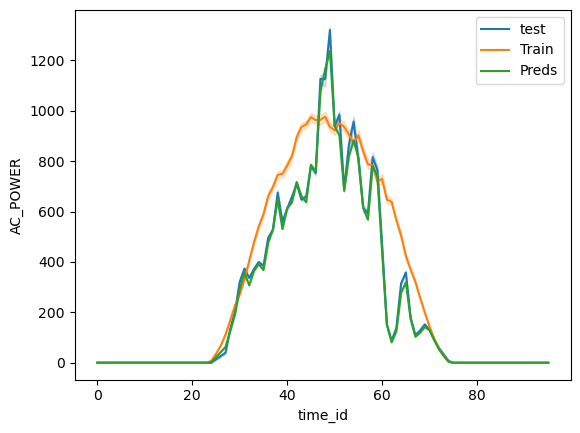

In [4]:

sns.lineplot(x=xx2['time_id'], y=yy2["AC_POWER"], label="test")
sns.lineplot(x=xx1['time_id'], y=yy1["AC_POWER"], label="Train")
sns.lineplot(x=xx2['time_id'], y=preds.reshape(preds.shape[0]),  label="Preds")

In [6]:
print(r2_score(preds, yy2))
print(mean_absolute_error(preds, yy2))
print(mean_squared_error(preds, yy2, squared=True))
print(mean_squared_error(preds, yy2, squared=False))

0.9927485160411441
13.607210063290346
804.0851140568775
28.35639458846765


## Conclusion

After adding multiple lagging 
We should be carefull to overfitting though, But since I don't have enough data, We'll consider this as a good model and predictions as etxremely good.
The only requirement for predicting is to predict the sensors beforehand.